# PixelCNN
In this notebook, we will implement a **PixelCNN generative model** for the **Amazing Logos dataset**.

**PixelCNN** is an autoregressive generative model that learns to generate images **pixel by pixel** in a sequential manner. Unlike VAEs that learn a latent representation, PixelCNN directly models the probability distribution of pixels conditioned on previously generated pixels.

This notebook is heavily based on [This Repo](https://github.com/henrhoi/pixelcnn-pytorch/tree/master)

## 📌 **What is PixelCNN?**

**PixelCNN** is an autoregressive generative model that generates images pixel-by-pixel, where each pixel is predicted based on all previously generated pixels. The key innovation is using **masked convolutions** to ensure the autoregressive property.

### 🔹 **Key Concepts:**
1️⃣ **Autoregressive Generation**: Each pixel depends only on previous pixels (spatial causality)

2️⃣ **Masked Convolutions**: Prevents "seeing into the future" during training

3️⃣ **Sequential Generation**: Images are generated one pixel at a time

4️⃣ **No Latent Space**: Directly models pixel probabilities

![PixelCNN Concept](https://i.imgur.com/uABKvYM.png)

### 🔹 **PixelCNN vs VAE:**
| **PixelCNN** | **VAE** |
|--------------|---------|
| Autoregressive | Latent variable model |
| Pixel-by-pixel generation | Encode → Sample → Decode |
| No compression | Learns compressed representation |
| Slower generation | Faster generation |
| Often sharper images | Sometimes blurrier images |


In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.utils import download_url
import os
import zipfile
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [39]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device for Apple Silicon GPU acceleration.")
else:
    device = torch.device("cpu")
    print("MPS device not found, falling back to CPU.")
print(f"当前使用的设备是: {device}")

Using MPS device for Apple Silicon GPU acceleration.
当前使用的设备是: mps



## 🎨 **Loading the Amazing Logos Dataset**

We'll use the **Amazing Logos** dataset from Hugging Face, which contains various logo designs. This is perfect for testing PixelCNN's ability to learn structured, symbolic patterns.

### 🔹 **Dataset Details:**
- **Source**: `iamkaikai/amazing_logos` from Hugging Face
- **Content**: Various logo designs and brand symbols
- **Challenge**: Logos have sharp edges, text, and geometric patterns
- **Preprocessing**: Convert to grayscale → Binary (black/white) for simplicity

In [40]:
class LogoDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.data = []

        # Download and extract the dataset if not already done
        self._download_and_extract()

        # Load image paths
        for filename in os.listdir(os.path.join(self.root, 'amazing-logos')):
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                self.data.append(os.path.join(self.root, 'amazing-logos', filename))

    def _download_and_extract(self):
        dataset_url = "https://github.com/henrhoi/pixelcnn-pytorch/raw/master/data/amazing-logos.zip"
        raw_folder = self.root
        processed_folder = os.path.join(self.root, 'amazing-logos')

        if not os.path.exists(processed_folder):
            print("Downloading and extracting amazing-logos dataset...")
            download_url(dataset_url, root=raw_folder, filename='amazing-logos.zip', md5=None)
            with zipfile.ZipFile(os.path.join(raw_folder, 'amazing-logos.zip'), 'r') as zip_ref:
                zip_ref.extractall(raw_folder)
            print("Dataset extracted!")
        else:
            print("Dataset already downloaded and extracted.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = Image.open(img_path).convert('RGB') # Convert to RGB first to handle various input formats

        if self.transform:
            image = self.transform(image)
        return image

### 🔹 **Image Preprocessing Pipeline**


In [41]:
# Define image transformations for logo processing
# We resize to a smaller size (64x64) for faster training and convert to binary
transform = transforms.Compose([
    transforms.Resize((64, 64)),           # Resize to 64x64 for manageable computation
    transforms.ToTensor(),                 # Convert PIL Image to tensor [0,1]
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale for simplicity
])

# Load the Amazing Logos dataset
hf_dataset = load_dataset("iamkaikai/amazing_logos", split="train[:1000]")
print(f"Dataset loaded successfully! Total images: {len(hf_dataset)}")

# Create custom dataset with transformations
logo_dataset = LogoDataset(hf_dataset, transform=transform)

# Convert to binary images (black and white) for PixelCNN
# This simplifies the learning task to binary classification per pixel
def binarize_batch(batch):
    """Convert grayscale images to binary (0 or 1) based on threshold"""
    return (batch > 0.5).float()

# Create data loader for training
batch_size = 128  
train_loader = DataLoader(logo_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

print(f"Training samples: {len(logo_dataset)}")
print(f"Batch size: {batch_size}")

HTTPError: HTTP Error 404: Not Found

In [ ]:
next(iter(train_loader)).shape

torch.Size([128, 1, 64, 64])

### 📊 **Let's visualize the dataset**


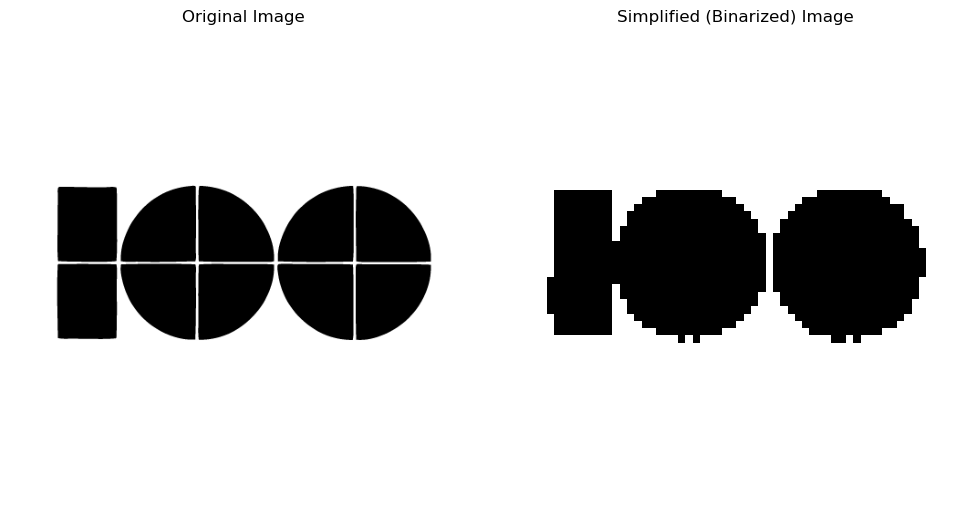

In [ ]:
# 可视化原始图像（未经过transform处理）
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# 原始图像（从hf_dataset中直接取出）
raw_img = hf_dataset[0]['image']
if isinstance(raw_img, np.ndarray):
    raw_img = Image.fromarray(raw_img)
axs[0].imshow(raw_img)
axs[0].set_title("Original Image")
axs[0].axis('off')

# 简化后的图像（经过transform和binarize处理）
simplified_img = transform(raw_img)
simplified_img = (simplified_img > 0.5).float()  # 二值化
axs[1].imshow(simplified_img.squeeze(), cmap='gray')
axs[1].set_title("Simplified (Binarized) Image")
axs[1].axis('off')

plt.tight_layout()
plt.show()

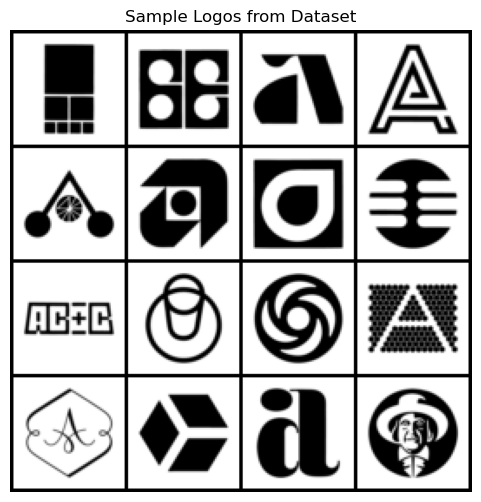

In [ ]:
# Visualize a batch of logo images from the dataset
images = next(iter(train_loader))
# Undo binarization for visualization if needed
grid = make_grid(images[:16], nrow=4, padding=2, normalize=True)
plt.figure(figsize=(6,6))
plt.axis('off')
plt.title("Sample Logos from Dataset")
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
plt.show()

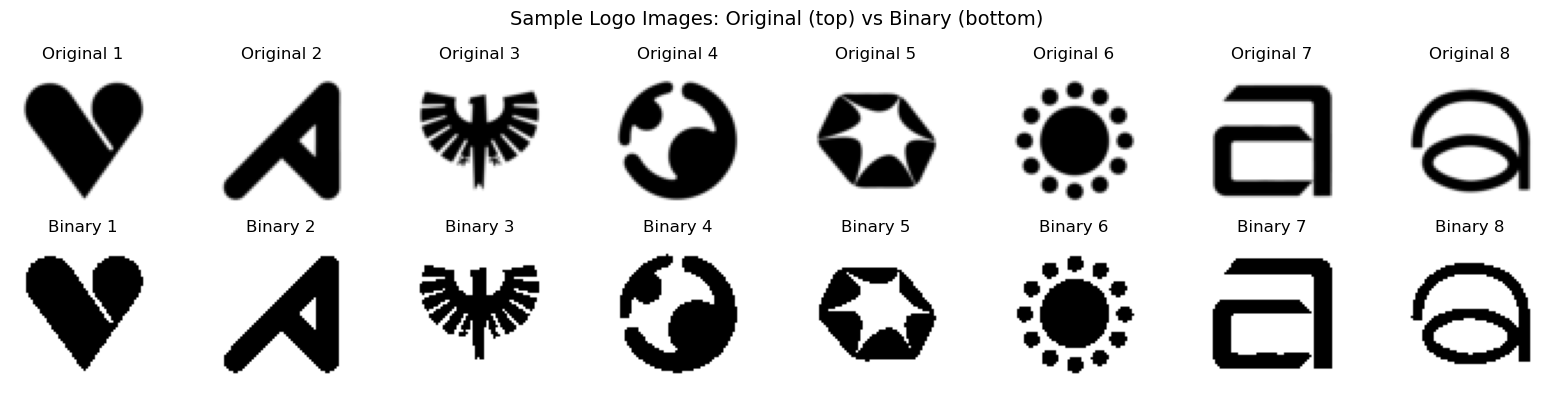

Image tensor shape: torch.Size([1, 64, 64])


In [ ]:
# Display sample logo images to verify data loading
data_iter = iter(train_loader)
sample_images = next(data_iter)
sample_images_binary = binarize_batch(sample_images)

# Show original and binarized images
fig, axes = plt.subplots(2, 8, figsize=(16, 4))

for i in range(8):
    # Original grayscale images (top row)
    axes[0, i].imshow(sample_images[i].squeeze(), cmap='gray')
    axes[0, i].set_title(f"Original {i+1}")
    axes[0, i].axis('off')

    # Binary images (bottom row) - what PixelCNN will learn
    axes[1, i].imshow(sample_images_binary[i].squeeze(), cmap='gray')
    axes[1, i].set_title(f"Binary {i+1}")
    axes[1, i].axis('off')

plt.suptitle("Sample Logo Images: Original (top) vs Binary (bottom)", fontsize=14)
plt.tight_layout()
plt.show()

print(f"Image tensor shape: {sample_images[0].shape}") 

## 🏗️ **Defining the PixelCNN Model**

### 🔹 **Understanding Masked Convolutions**

The core innovation of PixelCNN is **masked convolutions** that maintain the autoregressive property:

![Masked Convolution](https://camo.githubusercontent.com/2b432c6d87633c75685c3703167c0a6b5a6d6592a7ca95540bf02f6de890052c/68747470733a2f2f6c696c69616e77656e672e6769746875622e696f2f6c696c2d6c6f672f6173736574732f696d616765732f706978656c2d636e6e2e706e67)

- **Type A Mask**: Used in first layer, masks current pixel and all future pixels
- **Type B Mask**: Used in subsequent layers, allows current pixel but masks future pixels


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Assume 'device' is defined, e.g.,
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =============================================================================
# 1. Masked Convolution Layer (Slightly Improved)
# =============================================================================
# We'll make a small but important improvement to your original MaskedConv2d.
# Instead of modifying the weight tensor in-place with `self.weight.data *= ...`,
# we will apply the mask during the forward pass. This is a cleaner and safer
# way to ensure the mask is always applied without interfering with the optimizer's state.

class MaskedConv2d(nn.Conv2d):
    """
    A Convolutional layer masked to respect the auto-regressive property.
    For PixelCNN, this means a pixel can only see pixels above it and to its left.
    """
    def __init__(self, mask_type, *args, **kwargs):
        super().__init__(*args, **kwargs)
        assert mask_type in {'A', 'B'}, "mask_type must be 'A' or 'B'"

        # Create and register the mask as a buffer. A buffer is a tensor that is
        # part of the model's state but is not a parameter to be trained.
        # This is perfect for our fixed mask.
        self.register_buffer('mask', torch.ones_like(self.weight))

        # Get the spatial dimensions of the kernel
        _, _, kh, kw = self.weight.size()

        # Find the center of the kernel
        yc, xc = kh // 2, kw // 2

        # Zero out all pixels below the center row
        self.mask[:, :, yc+1:] = 0
        # Zero out all pixels to the right of the center in the center row
        self.mask[:, :, yc, xc+1:] = 0

        # For mask 'A', we also zero out the center pixel itself. This is used
        # in the very first layer to prevent the network from seeing the pixel
        # it is trying to predict.
        if mask_type == 'A':
            self.mask[:, :, yc, xc] = 0

    def forward(self, x):
        # Apply the mask to the weights before performing the convolution.
        masked_weight = self.weight * self.mask
        return F.conv2d(x, masked_weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)


# =============================================================================
# 2. Gated Residual Block (The Core Improvement)
# =============================================================================
# This is the new building block for our powerful PixelCNN. It contains the
# gated activation unit and a residual (skip) connection.

class GatedResidualBlock(nn.Module):
    def __init__(self, n_filters, kernel_size):
        super().__init__()
        padding = kernel_size // 2

        # The block consists of two masked convolutions and a 1x1 convolution
        # for the residual connection.

        # The first convolution doubles the number of channels. This is because
        # the output will be split in two for the gated activation.
        self.conv1 = MaskedConv2d('B', n_filters, 2 * n_filters, kernel_size, padding=padding)

        # A 1x1 convolution to process the gated output. This helps in mixing
        # information across channels.
        self.conv2 = MaskedConv2d('B', n_filters, n_filters, 1)

    def forward(self, x):
        # --- Main Path ---
        # 1. Pass input through the first masked convolution
        c1 = self.conv1(x)

        # 2. Gated Activation Unit
        # Split the output into two halves along the channel dimension
        # The first half goes into tanh, the second half is the "gate"
        a, b = torch.chunk(c1, 2, dim=1)
        gated_out = torch.tanh(a) * torch.sigmoid(b)

        # 3. Pass the gated output through the second masked convolution
        c2 = self.conv2(gated_out)

        # --- Residual Connection ---
        # Add the original input `x` to the output of our main path.
        # This allows the model to learn modifications to the identity function,
        # making it much easier to train very deep networks.
        return x + c2


# =============================================================================
# 3. The Powerful Gated PixelCNN Model
# =============================================================================
# This new model is significantly deeper and uses our new GatedResidualBlocks.

class PowerfulPixelCNN(nn.Module):
    def __init__(self, input_channels=1, n_filters=128, n_blocks=12, kernel_size=5, n_classes=256):
        super().__init__()

        # --- Initial Layer (Mask A) ---
        # The first layer must use Mask 'A' to prevent seeing the target pixel.
        # It projects the input channels (e.g., 1 for grayscale) to our
        # desired number of filters for the residual blocks.
        self.conv1 = MaskedConv2d('A', input_channels, n_filters, 7, padding=3)

        # --- Stack of Gated Residual Blocks ---
        # This is the main body of the network. We stack multiple residual blocks
        # to create a very deep and expressive model.
        self.blocks = nn.ModuleList([
            GatedResidualBlock(n_filters, kernel_size) for _ in range(n_blocks)
        ])

        # --- Output Layers ---
        # After the residual blocks, we use a couple of standard convolutions
        # to produce the final output. The output has `n_classes` channels,
        # representing the logits for each possible pixel value (e.g., 0-255).
        self.output_conv = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(n_filters, 512, 1), # 1x1 convolution
            nn.ReLU(),
            nn.Conv2d(512, n_classes, 1) # 1x1 convolution to get final logits
        )

    def forward(self, x):
        # 1. Pass through the initial layer
        x = self.conv1(x)

        # 2. Pass through the stack of residual blocks
        for block in self.blocks:
            x = block(x)

        # 3. Pass through the output layers to get the final logits
        x = self.output_conv(x)

        return x

# =============================================================================
# 4. Instantiate and Print the New Model
# =============================================================================
# Let's create an instance of our powerful model.
# It has 12 residual blocks, for a total of 1 (initial) + 12*2 (blocks) + 2 (output) = 27 conv layers!
# This is much deeper and more powerful than the original 7-layer model.

# Note: This model is designed for generating images with multiple intensity
# levels (e.g., 256 for grayscale), hence `n_classes=256`.
# The output will be a tensor of shape (batch, 256, height, width),
# which is then typically fed into a CrossEntropyLoss function.

powerful_pixelcnn = PowerfulPixelCNN(
    input_channels=1,
    n_filters=128,
    n_blocks=12,
    kernel_size=5,
    n_classes=256
).to(device)

print("--- Powerful Gated PixelCNN Architecture ---")
print(powerful_pixelcnn)

# You can compare this to the original model's printout. You'll see this
# new architecture is significantly more complex and deep, thanks to the
# Gated Residual Blocks.

--- Powerful Gated PixelCNN Architecture ---
PowerfulPixelCNN(
  (conv1): MaskedConv2d(1, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (blocks): ModuleList(
    (0-11): 12 x GatedResidualBlock(
      (conv1): MaskedConv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (conv2): MaskedConv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (output_conv): Sequential(
    (0): ReLU()
    (1): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1))
    (2): ReLU()
    (3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
  )
)


## 🚀 **Training the PixelCNN Model**

### 🔹 **Training Process Explained**

PixelCNN training is different from VAE:
1. **Input**: Binary logo images
2. **Target**: Same binary logo images (reconstruction task)
3. **Loss**: Binary Cross-Entropy between predicted and actual pixels
4. **Key**: Autoregressive property ensures proper causality


### 🏃‍♂️ **Training Loop**


In [ ]:
# Training loop for PowerfulPixelCNN

# Loss: Since we are using binary images (0 or 1), we can use BCEWithLogitsLoss.
# However, the model outputs 256 logits per pixel (for 256 classes), so we use CrossEntropyLoss.
# For binary images, we can treat pixel values as class 0 (black) or 1 (white).

# Prepare optimizer and loss function
optimizer = torch.optim.Adam(powerful_pixelcnn.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

num_epochs = 10  # You can increase this for better results

loss_history = []

for epoch in range(num_epochs):
    powerful_pixelcnn.train()
    epoch_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        # batch: [B, 1, 64, 64], values in {0,1}
        batch = batch.to(device)
        # Model expects input in [B, 1, H, W], output is [B, 256, H, W]
        logits = powerful_pixelcnn(batch)
        # For CrossEntropyLoss, targets must be LongTensor with values in [0, 255]
        # For binary, just multiply by 255 to get 0 or 255, then clamp to 0 or 1
        targets = (batch * 1).long().squeeze(1)  # [B, 64, 64], values 0 or 1

        # Only use first two channels of logits for binary classification
        logits_binary = logits[:, :2, :, :]  # [B, 2, 64, 64]

        loss = criterion(logits_binary, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")

Epoch 1/10: 100%|██████████| 8/8 [01:07<00:00,  8.47s/it]


Epoch 1/10 - Loss: 0.1157


Epoch 2/10: 100%|██████████| 8/8 [01:33<00:00, 11.63s/it]


Epoch 2/10 - Loss: 0.0000


Epoch 3/10: 100%|██████████| 8/8 [01:53<00:00, 14.20s/it]


Epoch 3/10 - Loss: 0.1716


Epoch 4/10: 100%|██████████| 8/8 [01:29<00:00, 11.13s/it]


Epoch 4/10 - Loss: 0.1708


Epoch 5/10: 100%|██████████| 8/8 [01:51<00:00, 13.93s/it]


Epoch 5/10 - Loss: 0.1701


Epoch 6/10: 100%|██████████| 8/8 [02:32<00:00, 19.11s/it]


Epoch 6/10 - Loss: 0.4224


Epoch 7/10: 100%|██████████| 8/8 [01:30<00:00, 11.34s/it]


Epoch 7/10 - Loss: 0.3372


Epoch 8/10: 100%|██████████| 8/8 [01:56<00:00, 14.60s/it]


Epoch 8/10 - Loss: 0.5054


Epoch 9/10: 100%|██████████| 8/8 [02:04<00:00, 15.51s/it]


Epoch 9/10 - Loss: 0.3370


Epoch 10/10: 100%|██████████| 8/8 [02:14<00:00, 16.77s/it]

Epoch 10/10 - Loss: 0.2528


### 📈 **Training Loss Visualization**


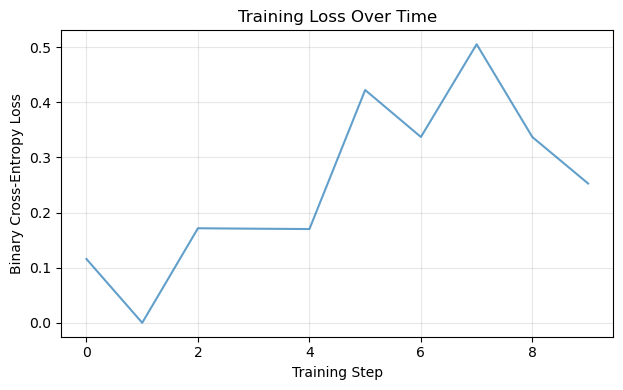

In [ ]:
# Plot training losses
plt.figure(figsize=(12, 4))

# Plot 1: Loss over all training steps
plt.subplot(1, 2, 1)
plt.plot(loss_history, alpha=0.7)
plt.title("Training Loss Over Time")
plt.xlabel("Training Step")
plt.ylabel("Binary Cross-Entropy Loss")
plt.grid(True, alpha=0.3)

# Plot 2: Smoothed loss (moving average)
window_size = 50
if len(loss_history) > window_size:
    smoothed_losses = np.convolve(loss_history, np.ones(window_size)/window_size, mode='valid')
    plt.subplot(1, 2, 2)
    plt.plot(smoothed_losses)
    plt.title(f"Smoothed Training Loss (window={window_size})")
    plt.xlabel("Training Step")
    plt.ylabel("Smoothed Loss")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 🎨 **Generating New Logo Samples**

### 🔹 **Autoregressive Generation Process**

This is where the magic happens! PixelCNN generates images **pixel by pixel** in a specific order:

1. **Start**: With blank canvas (all zeros)
2. **For each pixel position** (top→bottom, left→right):
   - Use model to predict probability of pixel being 1
   - Sample from Bernoulli distribution using this probability
   - Add sampled pixel to canvas
3. **Repeat**: Until entire image is generated

![Generation Process](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-16_at_7.27.51_PM_tpsd8Td.png)

In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def generate_logos(model, num_samples=16, image_size=64):
    """
    🎨 Generate new logo images using trained PixelCNN

    This function implements the autoregressive generation process:
    1. Start with blank canvas (all zeros)
    2. For each pixel position (top-to-bottom, left-to-right):
        - Use model to predict probability of pixel being 1
        - Sample from the distribution using this probability
        - Add sampled pixel to canvas
    3. Repeat until entire image is generated

    Args:
        model: Trained PixelCNN model
        num_samples: Number of logos to generate
        image_size: Size of generated images

    Returns:
        Generated logo images as a tensor for visualization
    """
    # Set model to evaluation mode
    model.eval()

    # Initialize blank canvas
    H, W = image_size, image_size
    samples = torch.zeros(size=(num_samples, 1, H, W)).to(device)

    with torch.no_grad():
        total_pixels = H * W
        progress_bar = tqdm(total=total_pixels, desc="Generating pixels")

        for i in range(H):  # For each row
            for j in range(W):  # For each column
                # --- FIX STARTS HERE ---

                # 1. Get model logits for the current state.
                # The undefined normalize_for_model() call is removed.
                output = model(samples)

                # 2. Isolate the logits for the two classes (0 and 1) at the current pixel.
                logits_binary = output[:, :2, i, j]  # Shape: [N, 2]

                # 3. Convert logits to probabilities using softmax.
                probs = F.softmax(logits_binary, dim=1) # Shape: [N, 2]

                # 4. Sample from the distribution (0 or 1) for each image in the batch.
                # torch.multinomial is used to sample indices based on probabilities.
                sampled_pixels = torch.multinomial(probs, 1) # Shape: [N, 1]

                # 5. Place the sampled pixel (0 or 1) onto the canvas.
                # .squeeze() removes the extra dimension, .float() converts to float.
                samples[:, 0, i, j] = sampled_pixels.squeeze().float()

                # --- FIX ENDS HERE ---
                progress_bar.update(1)

        progress_bar.close()

    return samples.cpu()

In [ ]:
generated_samples = generate_logos(powerful_pixelcnn, num_samples=16, image_size=64)

Generating pixels: 100%|██████████| 4096/4096 [20:21<00:00,  3.35it/s]


### 🖼️ **Displaying Generated Results**


In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def generate_samples(model, num_samples, image_size, device):
    """
    Generates new images pixel by pixel using the trained PixelCNN model.

    Args:
        model (nn.Module): The trained PixelCNN model.
        num_samples (int): The number of images to generate.
        image_size (int): The height and width of the square images (e.g., 64 for 64x64).
        device (torch.device): The device (CPU or GPU) to perform generation on.

    Returns:
        torch.Tensor: A tensor containing the generated images,
                      with pixel values normalized to [0.0, 1.0].
    """
    model.eval() # Set the model to evaluation mode
    # Initialize a batch of empty images (all zeros) on the specified device
    # Shape: (num_samples, channels, height, width). Here, channels=1 for grayscale.
    samples = torch.zeros(num_samples, 1, image_size, image_size).to(device)

    # Disable gradient calculation for inference
    with torch.no_grad():
        # Iterate over each pixel location (row by row, then column by column)
        # to generate the image autoregressively.
        for i in tqdm(range(image_size), desc="Generating rows"):
            for j in range(image_size):
                # Predict the pixel value at (i, j) based on all previously generated pixels.
                # The model's output 'output' will have shape (batch_size, 256, H, W)
                # where 256 corresponds to the 256 possible pixel values (0-255).
                output = model(samples)

                # Get the logits for the current pixel (i, j) across all 256 channels.
                # output[:, :, i, j] gives (batch_size, 256)
                logits_for_pixel = output[:, :, i, j]

                # Convert logits to probabilities using softmax.
                # dim=1 means softmax is applied across the 256 channels for each sample.
                probs = F.softmax(logits_for_pixel, dim=1)

                # Sample a pixel value from the predicted categorical distribution.
                # torch.multinomial samples an integer from 0 to 255.
                # .float() converts it to a float, and / 255.0 normalizes it to [0.0, 1.0].
                pixel_val = torch.multinomial(probs, 1).float() / 255.0

                # Assign the sampled pixel value to the current pixel location in the samples tensor.
                # .squeeze(1) removes the extra dimension added by torch.multinomial
                # (e.g., from (batch_size, 1) to (batch_size,)).
                samples[:, 0, i, j] = pixel_val.squeeze(1)

    return samples

Generating samples...


Generating rows: 100%|██████████| 64/64 [15:06<00:00, 14.17s/it]

Samples generated.
Displaying generated samples...


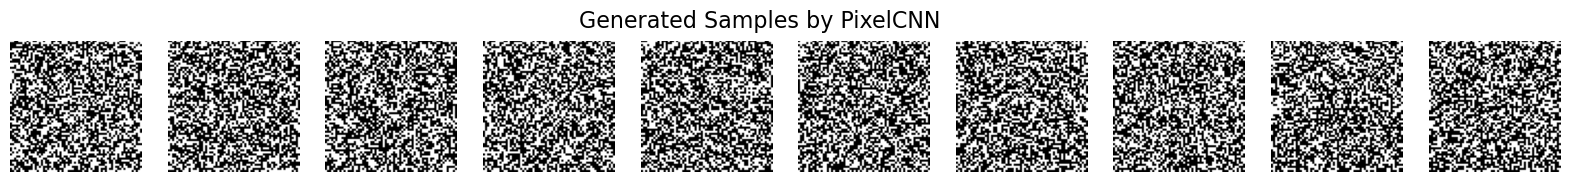

Display complete.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Set image_size to match your dataset and model
image_size = 64

# Assume 'model', 'device' are defined, and 'generate_samples' function is available from previous cells.
# For example:
# model = PixelCNN(in_channels=1).to(device)
# # Load your trained model weights here if needed
# # model.load_state_dict(torch.load('path_to_your_model.pth'))
# image_size = 64 # Or whatever your image_size is

# Generate samples using the trained model
print("Generating samples...")
num_samples_to_display = 10
generated_samples = generate_samples(powerful_pixelcnn, num_samples=num_samples_to_display, image_size=image_size, device=device)
print("Samples generated.")

# Apply binarization for display.
# Since the model was trained on binarized images (0 or 1),
# forcing the generated output to be binary (0 or 1) makes the visualization consistent.
# Values > 0.5 become 1.0 (white), and <= 0.5 become 0.0 (black).
generated_samples_binarized = (generated_samples > 0.5).float() #

# Visualize generated samples
print("Displaying generated samples...")
fig, axes = plt.subplots(1, num_samples_to_display, figsize=(20, 2))
for i, ax in enumerate(axes):
    # For grayscale images, squeeze the channel dimension (1, H, W) -> (H, W)
    img_to_display = generated_samples_binarized[i].squeeze(0).cpu().numpy() #
    ax.imshow(img_to_display, cmap='gray') # Use 'gray' colormap for grayscale images
    ax.axis('off') # Hide axes for cleaner display
plt.suptitle("Generated Samples by PixelCNN", fontsize=16)
plt.show()
print("Display complete.")

## 🧪 **Experiments to Try**

### 📝 **Suggested Modifications:**
1. **Model Size**: Try different `conv_filters` (32, 128, 256)
2. **Image Resolution**: Experiment with 32x32 vs 128x128 images
3. **Color Channels**: Extend to RGB logos (3 channels)
    - THIS IS HARD.
    - If you want to see one that actually worked [OpenAI Implementation of PixelCNN in Tensorflow](https://github.com/openai/pixel-cnn)
4. **Architecture**: Add more layers or residual connections
5. **Training**: Longer training (200+ epochs) for better quality

### Contributed by: Ali Habibullah. 